<a href="https://colab.research.google.com/github/susant146/PyTorch_Basics_CNNmodels/blob/main/Custom_Dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from collections import OrderedDict

import torch
import torch.nn as nn
import os
import cv2  # for image reading and processing
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torch.utils.data import random_split
from matplotlib import pyplot as plt

**Device setup for CUDA usage**

In [ ]:
import os
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**Mount Drive to Access Image Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Image Denoising Custom Dataloader

In [ ]:
# Function to add Gaussian noise to the image
# Note: image should be between [0,1] & std = [0,1]
# noisy_image clipped between [0,1]
def add_gaussian_noise(image, std):
    noise = np.random.normal(0, std, image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 1)
    return noisy_image

In [ ]:
class DenoiseDataset(Dataset):
    def __init__(self, image_dir, noise_std_range, transform=None):
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.noise_std_range = noise_std_range
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        image = image.astype(np.float32)
        image_resized = cv2.resize(image, (256, 256))

        # Add Gaussian noise
        std = np.random.uniform(self.noise_std_range[0], self.noise_std_range[1])
        std = std/255.0     # std normalized to image dynamic range
        # Normalize the image
        image_resized /= 255.0
        noisy_image = add_gaussian_noise(image_resized, std)


        if self.transform:
            image_resized = self.transform(image_resized)
            noisy_image = self.transform(noisy_image)

        return image_resized, noisy_image  # return noisy and clean image pair

**Create DataLoader**

In [ ]:
# Hyperparameters
batch_size = 32
noise_std_range = (20, 20)  # Gaussian noise std range

# Image transformations
transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))
])

# Create Dataset and DataLoader
dataset = DenoiseDataset(image_dir='/content/drive/MyDrive/images',
                         noise_std_range=noise_std_range,
                         transform=transform)

**Training, Test and validation Data-Splitting**

In [ ]:
# dataset contains all the image data and the corresponding noisy image
# We will divide the image data in 80% Training, 10% Test and 10% Validation data.
dataset_size = len(dataset)
print('Total image data in the dataset: ', dataset_size)
train_size = int(0.80 * dataset_size)  # 80% for training
val_size = int(0.10 * dataset_size)    # 10% for validation
test_size = dataset_size - train_size - val_size  # 10% for testing

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Total image data in the dataset:  3443


In [ ]:
# set num_workers equal to the number of CPU cores on that machine
# Check for avaiable num workers (cores) in the cpu
num_workers = os.cpu_count()
print(f"Available CPU cores: {num_workers}")

Available CPU cores: 2


In [ ]:
# Now create Train_dataset, test_dataset and val_dataset from these data.
# We will see how to send these data into devices also.

# Number of workers for data loading (set based on your system)
num_workers = 2  # Adjust based on your system

# Create DataLoaders with num_workers and pin_memory optimization
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

**Visualizing Train, test and validation data**

In [ ]:
train_images, train_noisy_images = next(iter(train_loader))  # Get a batch of train image data.
test_images, test_noisy_images = next(iter(test_loader))  # Get a batch of train image data.
val_images, val_noisy_images = next(iter(val_loader))  # Get a batch of train image data.

print('Batch size, Channels, Width, Height',train_images.unsqueeze(1).shape)

Batch size, Channels, Width, Height torch.Size([32, 1, 1, 256, 256])


batch size, height, width (32, 256, 256)
Max and Min value in image data 1.0 -1.0
Denormalize: Max and Min value 1.0 0.0
Denorm Max and Min value in image data 1.0 0.0


Text(0.5, 1.0, 'Train Noisy img - 1')

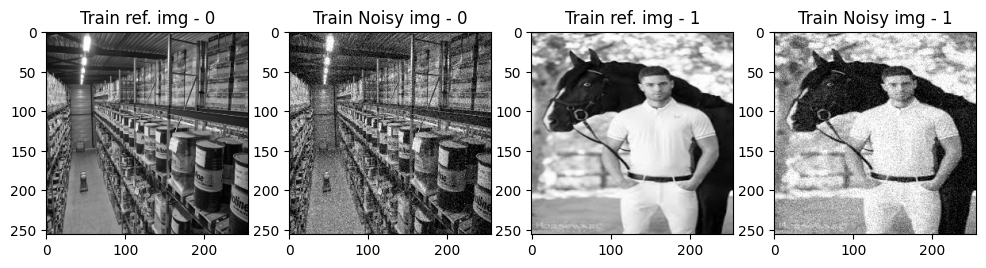

In [ ]:
# Load a single image and convert it to numpy() array
train_img = train_images.squeeze(1).numpy()
print('batch size, height, width', train_img.shape)

# Images are normalized between -1 to 1
print('Max and Min value in image data', train_img[0].max(), train_img.min())
# Denormalize images [0, 1] range
train_img_denorm = train_img * 0.5 + 0.5
print('Denormalize: Max and Min value', train_img_denorm[0].max(), train_img_denorm[0].min())

# Noisy image
train_noisy_img = train_noisy_images.squeeze(1).numpy()
train_noisy_img_denorm = train_noisy_img * 0.5 + 0.5
print('Denorm Max and Min value in image data', train_noisy_img_denorm[0].max(), train_noisy_img_denorm.min())

# Now display train image and the corresponding noisy version using matplotlib
plt.figure(figsize=[12, 12])
plt.subplot(1, 4, 1)
plt.imshow(train_img_denorm[0], cmap='gray')
plt.title('Train ref. img - 0')

plt.subplot(1, 4, 2)
plt.imshow(train_noisy_img_denorm[0], cmap='gray')
plt.title('Train Noisy img - 0')

plt.subplot(1, 4, 3)
plt.imshow(train_img_denorm[1], cmap='gray')
plt.title('Train ref. img - 1')

plt.subplot(1, 4, 4)
plt.imshow(train_noisy_img_denorm[1], cmap='gray')
plt.title('Train Noisy img - 1')


**Pushing images into CUDA**

In [ ]:
# This example will be on test and validation dataloader
# but same can be done for training images.

test_img_gpu = test_images.to(device).float()
test_noisy_img_gpu = test_noisy_images.to(device).float()

# val_img_gpu = val_images.to(device)#.float()
# val_noisy_img_gpu = val_noisy_images.to(device)#.float()
# del val_img_gpu  # Delete specific tensor
# del val_noisy_img_gpu  # Delete specific tensor


In [ ]:
# torch.cuda.memory_allocated()
# torch.cuda.empty_cache() # After deleting variable empty unused data
!nvidia-smi

Mon Feb  3 10:24:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P0             29W /   70W |     154MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

batch size, height, width (32, 256, 256)


Text(0.5, 1.0, 'Test Noisy img - 1')

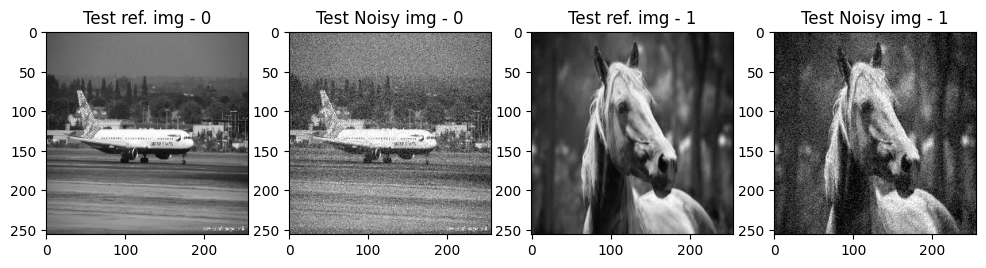

In [ ]:
# Now fetch images from CUDA to CPU
# Display Images using matplotlib
# Load a single image and convert it to numpy() array
test_img = test_img_gpu.squeeze(1).cpu().numpy()
print('batch size, height, width', test_img.shape)
test_img_denorm = test_img * 0.5 + 0.5

# Noisy image
test_noisy_img = test_noisy_img_gpu.squeeze(1).cpu().numpy()
test_noisy_img_denorm = test_noisy_img * 0.5 + 0.5

# Now display train image and the corresponding noisy version using matplotlib
plt.figure(figsize=[12, 12])
plt.subplot(1, 4, 1)
plt.imshow(test_img_denorm[0], cmap='gray')
plt.title('Test ref. img - 0')

plt.subplot(1, 4, 2)
plt.imshow(test_noisy_img_denorm[0], cmap='gray')
plt.title('Test Noisy img - 0')

plt.subplot(1, 4, 3)
plt.imshow(test_img_denorm[1], cmap='gray')
plt.title('Test ref. img - 1')

plt.subplot(1, 4, 4)
plt.imshow(test_noisy_img_denorm[1], cmap='gray')
plt.title('Test Noisy img - 1')

**PSNR and SSIM: Getting Image Quality**

In [ ]:
train_img1 = train_img_denorm[0];
train_noisy_img1 = train_noisy_img_denorm[0];

psnrVal = psnr(train_img1, train_noisy_img1, data_range=1.0)
ssimVal = ssim(train_img1, train_noisy_img1, data_range=1.0)
print('PSNR: ', psnrVal)
print('SSIM: ', ssimVal)

PSNR:  22.27002214070565
SSIM:  0.7289323346852139
